In [1]:
# ░░ Cell 1  ░░░  Imports & global knobs
import os, glob
from concurrent.futures import ProcessPoolExecutor

import cv2
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
import matplotlib.pyplot as plt


In [2]:
# ░░░ Cell 2  ░░░  Helper functions
def load_yolo_boxes(txt_path: str, img_w: int, img_h: int):
    """Parse a YOLO .txt -> [(x1,y1,x2,y2,class_id), …]."""
    boxes = []
    with open(txt_path) as f:
        for line in f:
            cls, xc, yc, w, h = map(float, line.split())
            x1 = int((xc - w/2) * img_w)
            x2 = int((xc + w/2) * img_w)
            y1 = int((yc - h/2) * img_h)
            y2 = int((yc + h/2) * img_h)
            x1, x2 = np.clip([x1, x2], 0, img_w-1)
            y1, y2 = np.clip([y1, y2], 0, img_h-1)
            boxes.append((x1, y1, x2, y2, int(cls)))
    return boxes

# ░░░ Cell 2  ░░░  Helpers with 8-bit normalisation  (Option A)
import cv2, numpy as np
from pathlib import Path

# ░░░ Cell 2  ░░░  Helpers with 8-bit normalisation (Py < 3.10 safe)
import cv2, numpy as np
from pathlib import Path
from typing import Union, Optional
from scipy.stats import kurtosis

def load_grayscale_8u(path: Union[str, Path]) -> Optional[np.ndarray]:
    """
    Load any PNG/JPG/TIFF as grayscale and rescale to uint8 [0,255].
    Works the same for 8-bit, 16-bit, or float images.
    """
    img = cv2.imread(str(path), cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = img.astype(np.float32)
    rng = img.max() - img.min()
    if rng < 1e-6:                # completely flat
        return np.zeros_like(img, dtype=np.uint8)

    img = (img - img.min()) / rng      # 0–1
    return (img * 255).astype(np.uint8)

def _stat(arr: np.ndarray, which: str):
    return float(arr.mean()) if which == "mean" else float(kurtosis(arr, fisher=False, bias=False))

def _process_one(args):
    img_path, txt_path, stat = args
    img = load_grayscale_8u(img_path)
    if img is None or not Path(txt_path).exists():
        return []

    h, w = img.shape
    boxes = load_yolo_boxes(txt_path, w, h)
    if not boxes:
        return []

    outside = np.ones((h, w), bool)
    rows = []
    for idx, (x1, y1, x2, y2, cls) in enumerate(boxes):
        m = np.zeros((h, w), bool)
        m[y1:y2, x1:x2] = True
        inside_val = _stat(img[m], stat)
        outside[y1:y2, x1:x2] = False
        rows.append(
            dict(
                split   = Path(img_path).parent.parent.name,
                image   = Path(img_path).name,
                box_idx = idx,
                cls     = cls,
                inside  = inside_val,
            )
        )

    outside_val = _stat(img[outside], stat)
    for r in rows:
        r["outside"] = outside_val
        r["diff"]    = r["inside"] - outside_val
        r["metric"]  = stat
    return rows


In [3]:
# ░░░ Cell 3  ░░░  Batch compute  (fixed for Python <3.10)
from typing import Optional  # add this import

def compute_box_stats(
    images_dir: str,
    labels_dir: str,
    stats=("mean", "kurt"),
    n_workers: Optional[int] = None
) -> pd.DataFrame:
    img_paths = sorted(
        p for p in glob.glob(os.path.join(images_dir, "*"))
        if p.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"))
    )
    all_rows = []
    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        for stat in stats:
            for rows in ex.map(
                _process_one,
                img_paths,
                [stat] * len(img_paths),
                [labels_dir] * len(img_paths)    # ← new
            ):
                all_rows.extend(rows)
    return pd.DataFrame(all_rows)




In [4]:
# ░░░ Cell 4  ░░░  Plot helpers (robust version)
def plot_stats(df: pd.DataFrame, stat: str):
    # If the DataFrame lacks the 'metric' column, assume it already
    # contains only rows for the requested stat.
    if "metric" in df.columns:
        sub = df[df["metric"] == stat]
    else:
        sub = df.copy()

    # Histogram
    plt.figure(figsize=(8, 4))
    plt.hist(sub["inside"], 50, alpha=0.6, label="inside")
    plt.hist(sub["outside"], 50, alpha=0.6, label="outside")
    plt.title(f"{stat.capitalize()} distribution")
    plt.xlabel(stat)
    plt.ylabel("count")
    plt.legend()
    plt.show()

    # Box-by-class Δ
    if sub["cls"].nunique() > 1:
        plt.figure(figsize=(8, 4))
        sub.boxplot(column="diff", by="cls")
        plt.suptitle("")
        plt.title(f"{stat.capitalize()} (inside−outside) by class")
        plt.xlabel("class")
        plt.ylabel(f"Δ {stat}")
        plt.show()

    # Scatter inside vs Δ
    plt.figure(figsize=(5, 5))
    plt.scatter(sub["inside"], sub["diff"], s=8, alpha=0.7)
    plt.axhline(0, ls="--", lw=1)
    plt.xlabel(f"{stat} (inside)")
    plt.ylabel(f"Δ {stat}")
    plt.title(f"{stat.capitalize()} separation")
    plt.show()



In [5]:
# # ░░░ Cell 5  ░░░  Run it!
# from pathlib import Path
# root        = Path("/datax/scratch/jliang/dataset_final_7/train")   # adjust!
# images_dir  = root / "images"
# labels_dir  = root / "labels"

# stats   = ("mean", "kurt")   # or ("mean",) / ("kurt",)
# workers = None               # CPU cores

# df_stats = compute_box_stats(images_dir, labels_dir, stats, workers)
# df_stats.head()



In [6]:
# # ░░░ Walk an entire YOLO-style dataset and compute stats ░░░
# import os, glob, cv2, numpy as np, pandas as pd
# from pathlib import Path
# from concurrent.futures import ProcessPoolExecutor
# from typing import Optional
# from scipy.stats import kurtosis

# # ---------------- core helpers ----------------
# def load_yolo_boxes(txt_path: Path, w: int, h: int):
#     boxes = []
#     for line in txt_path.read_text().splitlines():
#         if not line.strip():
#             continue
#         cls, xc, yc, bw, bh = map(float, line.split())
#         x1 = int((xc - bw / 2) * w)
#         x2 = int((xc + bw / 2) * w)
#         y1 = int((yc - bh / 2) * h)
#         y2 = int((yc + bh / 2) * h)
#         x1, x2 = np.clip([x1, x2], 0, w - 1)
#         y1, y2 = np.clip([y1, y2], 0, h - 1)
#         boxes.append((x1, y1, x2, y2, int(cls)))
#     return boxes

# def _stat(arr: np.ndarray, which: str):
#     return float(arr.mean()) if which == "mean" else float(kurtosis(arr, fisher=False, bias=False))

# def _process_one(args):
#     img_path, txt_path, stat = args
#     img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
#     if img is None:
#         return []                       # unreadable ⇒ skip
#     h, w = img.shape[:2]
#     boxes = load_yolo_boxes(txt_path, w, h)
#     if not boxes:
#         return []                       # empty label ⇒ skip

#     outside = np.ones((h, w), bool)
#     rows = []
#     for idx, (x1, y1, x2, y2, cls) in enumerate(boxes):
#         m = np.zeros((h, w), bool)
#         m[y1:y2, x1:x2] = True
#         inside_val = _stat(img[m].ravel(), stat)
#         outside[y1:y2, x1:x2] = False
#         rows.append(dict(
#             split   = img_path.parent.parent.name,   # train / val / test
#             image   = img_path.name,
#             box_idx = idx,
#             cls     = cls,
#             inside  = inside_val
#         ))
#     outside_val = _stat(img[outside].ravel(), stat)
#     for r in rows:
#         r["outside"] = outside_val
#         r["diff"]    = r["inside"] - outside_val
#         r["metric"]  = stat
#     return rows

# def compute_dataset_stats(
#     root: str,
#     stats = ("mean", "kurt"),
#     n_workers: Optional[int] = None
# ) -> pd.DataFrame:
#     root = Path(root)
#     # collect every (image, label) pair under */images/* & */labels/*
#     img_label_pairs = []
#     for img_path in root.rglob("images/*"):
#         if img_path.suffix.lower() not in {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}:
#             continue
#         txt_path = img_path.with_name(img_path.stem + ".txt").with_suffix(".txt") \
#                            .parent.parent / "labels" / f"{img_path.stem}.txt"
#         if txt_path.exists():
#             img_label_pairs.append((img_path, txt_path))
#     if not img_label_pairs:
#         raise RuntimeError("No image–label pairs found - check the folder structure!")

#     rows_all = []
#     with ProcessPoolExecutor(max_workers=n_workers) as ex:
#         for stat in stats:
#             args_iter = [(img, txt, stat) for img, txt in img_label_pairs]
#             for rows in ex.map(_process_one, args_iter):
#                 rows_all.extend(rows)
#     return pd.DataFrame(rows_all)

# # ---------------- run it ----------------
# dataset_root = "/datax/scratch/jliang/dataset_final_7"   # <-- CHANGE ME
# stats        = ("mean", "kurt")                 # or ("mean",)
# workers      = None                             # None = all CPU cores

# df_stats = compute_dataset_stats(dataset_root, stats, workers)
# print(df_stats.shape)   # (rows, cols)  – should be > 0
# df_stats.head()


In [7]:
# import matplotlib.pyplot as plt
# for s in stats:
#     plot_stats(df_stats[df_stats.metric == s], s)


In [8]:
def compute_dataset_stats(
    root: str,
    stats = ("mean", "kurt"),
    n_workers: Optional[int] = None
) -> pd.DataFrame:
    root = Path(root)
    # collect every (image, label) pair under */images/* & */labels/*
    img_label_pairs = []
    for img_path in root.rglob("images/*"):
        if img_path.suffix.lower() not in {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}:
            continue
        txt_path = img_path.with_name(img_path.stem + ".txt").with_suffix(".txt") \
                           .parent.parent / "labels" / f"{img_path.stem}.txt"
        if txt_path.exists():
            img_label_pairs.append((img_path, txt_path))
    if not img_label_pairs:
        raise RuntimeError("No image–label pairs found - check the folder structure!")

    rows_all = []
    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        for stat in stats:
            args_iter = [(img, txt, stat) for img, txt in img_label_pairs]
            for rows in ex.map(_process_one, args_iter):
                rows_all.extend(rows)
    return pd.DataFrame(rows_all)

# ---------------- run it ----------------
dataset_root = "/datax/scratch/jliang/dataset_final_7"   # <-- CHANGE ME
stats        = ("mean", "kurt")                 # or ("mean",)
workers      = None                             # None = all CPU cores

df_stats = compute_dataset_stats(dataset_root, stats, workers)
print(df_stats.shape)   # (rows, cols)  – should be > 0
df_stats.head()


(78552, 8)


,split,image,box_idx,cls,inside,outside,diff,metric
0,train,img_31.19_f_1688.9648_1686.0380.png,0,0,58.010911,46.928739,11.082173,mean
1,train,img_514.72_f_1647.9492_1645.0224.png,0,0,11.692444,6.357531,5.334913,mean
2,train,img_514.72_f_1647.9492_1645.0224.png,1,0,9.074914,6.357531,2.717383,mean
3,train,img_89.34_f_1618.6523_1615.7255.png,0,0,10.027149,6.784146,3.243004,mean
4,train,img_89.34_f_1618.6523_1615.7255.png,1,0,15.777859,6.784146,8.993713,mean


In [9]:
# ░░░ Publication-quality plots for mean difference ░░░
import os, seaborn as sns, matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_context("talk")          # larger fonts

def plot_mean_diff(df, out_dir="plots_mean_diff",
                   bins=60, clip_pct=0.5):
    """
    clip_pct = percentage (0–100) of *each* tail to clip.
    0.5 → drop the bottom 0.5 % and top 0.5 % of values.
    """
    import seaborn as sns, matplotlib.pyplot as plt, os
    sns.set_style("whitegrid"); sns.set_context("talk")
    os.makedirs(out_dir, exist_ok=True)

    diff_full = df["diff"].copy()
    # ─── ❶ robust clipping ─────────────────────────────────────────
    # Use a tighter window: 0.5 %–99.5 % range   (or tweak pct as you like)
    lo, hi = np.percentile(diff_full, [0.5, 99.5])

        # ----- keep only that window for plotting & axis -----
    diff = diff_full[(diff_full >= lo) & (diff_full <= hi)]
    dropped = len(diff_full) - len(diff)

    # ─── ❷ histogram + KDE ────────────────────────────────────────
    # ── ❷ histogram + KDE ──────────────────────────────────────────
    plt.figure(figsize=(10,4))
    ax = sns.histplot(diff, bins=bins, kde=True,
                    color="#1f77b4", edgecolor="k")
    ax.set_xlim(lo, hi)
    ax.axvline(0, ls="--", lw=1.5, color="k")

    # --- stats box -------------------------------------------------
    mu, med, std = diff.mean(), diff.median(), diff.std()
    txt  = (f"$\\mu$ = {mu:.2f}\n"
            f"med = {med:.2f}\n"
            f"σ = {std:.2f}\n"
            f"clipped {dropped} boxes")

    # Put the box *just outside* the top-right of the axes:
    ax.text(1.02, 0.98, txt,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3",
                    fc="white", ec="gray", alpha=0.9))

    ax.set(title="Distribution of Mean Difference (inside − outside)",
        xlabel="Mean difference (gray-levels)",
        ylabel="Number of boxes")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "hist_mean_diff_clipped.png"), dpi=300,
                bbox_inches="tight")   # ensure extra width is saved
    plt.show()

# plot_mean_diff(df_stats)


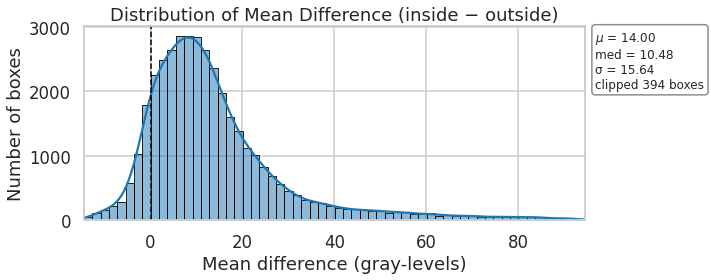

In [10]:
# ░░░ Cell 2 (helpers) already updated with load_grayscale_8u  ░░░

# ░░░ Cell 3 — recompute stats  ░░░
df_stats = compute_dataset_stats(dataset_root, stats=("mean",))

# ░░░ Cell 4 — plot  ░░░
plot_mean_diff(df_stats, clip_pct=0.5)   # or any clip_pct you like


In [16]:
print(df_stats["inside"].min(), df_stats["inside"].max())
print(df_stats["outside"].min(), df_stats["outside"].max())
print(df_stats["diff"].min(), df_stats["diff"].max())


1.1798097247312687 1184.7137950625313
1.0987249712233957 18758.85594581506
-18687.8879081358 1164.3804061361502


In [6]:
# add Signal-to-Background Ratio (linear + dB)
EPS = 1e-6              # avoids division-by-zero
df_stats = df_stats.copy()              # keep original intact
df_stats["sbr_lin"] = df_stats["inside"] / (df_stats["outside"] + EPS)
df_stats["sbr_dB"]  = 10 * np.log10(df_stats["sbr_lin"] + EPS)

df_stats[["inside", "outside", "sbr_lin", "sbr_dB"]].head()


,inside,outside,sbr_lin,sbr_dB
0,58.010671,46.928739,1.236144,0.920694
1,11.692444,6.357524,1.839150,2.646174
2,9.074914,6.357524,1.427429,1.545547
3,10.026647,6.784146,1.477952,1.696608
4,15.777859,6.784146,2.325695,3.665530


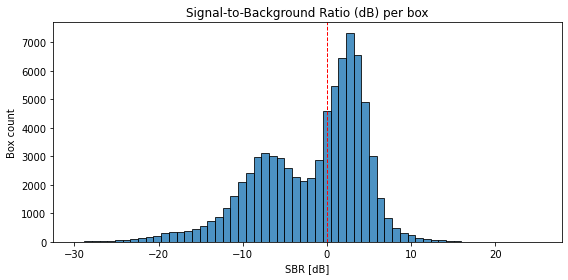

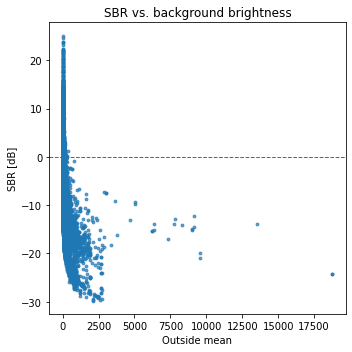

In [7]:
def plot_sbr(df: pd.DataFrame):
    # 1) Histogram of SBR (dB)
    plt.figure(figsize=(8,4))
    plt.hist(df["sbr_dB"], bins=60, alpha=0.8, edgecolor="k")
    plt.title("Signal-to-Background Ratio (dB) per box")
    plt.xlabel("SBR [dB]")
    plt.ylabel("Box count")
    plt.axvline(0, ls="--", lw=1, color="r")
    plt.tight_layout()
    plt.show()

    # 2) Boxplot of SBR by class (if multiple classes)
    if df["cls"].nunique() > 1:
        plt.figure(figsize=(8,4))
        df.boxplot(column="sbr_dB", by="cls")
        plt.suptitle("")
        plt.title("SBR (dB) by class")
        plt.xlabel("class")
        plt.ylabel("SBR [dB]")
        plt.tight_layout()
        plt.show()

    # 3) Scatter: outside mean vs. SBR
    plt.figure(figsize=(5,5))
    plt.scatter(df["outside"], df["sbr_dB"], s=8, alpha=0.7)
    plt.xlabel("Outside mean")
    plt.ylabel("SBR [dB]")
    plt.title("SBR vs. background brightness")
    plt.axhline(0, ls="--", lw=1)
    plt.tight_layout()
    plt.show()

plot_sbr(df_stats)


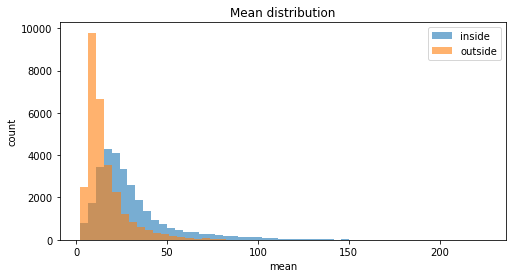

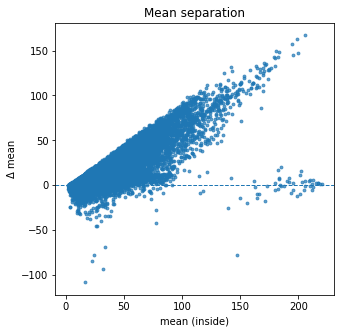

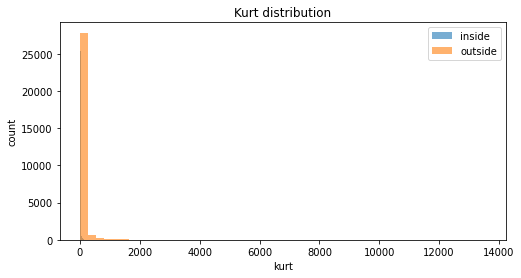

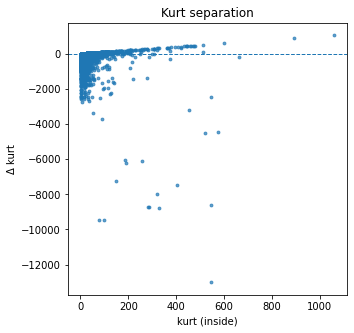

In [10]:
# ░░░ Cell 6  ░░░  Visualise
# Run once, then plots will work
rename_map = {
    'stat_inside': 'inside',
    'stat_outside': 'outside',
    'stat_diff': 'diff'
}
df_stats = df_stats.rename(columns=rename_map, errors='ignore')

for s in stats:
    plot_stats(df_stats, s)
